In [36]:
import thingspeak
import pandas as pd
import json
import ssl
import plotly.express as px
import numpy as np
import plotly.io as pio
import datetime
from sklearn.model_selection import train_test_split
import math
import seaborn as sn
from typing import Tuple
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

ssl._create_default_https_context = ssl._create_unverified_context



In [2]:
API_KEY = "ZRDS32VNQEEFSOF4"
CHANNEL_ID = "1361623"

fields = {
    "field2": "TEMP [C]", 
    "field3":"Relative humidity", 
    "field4":"PM1 [ug/m3]", 
    "field5":"PM2.5 [ug/m3]", 
    "field6":"PM10 [ug/m3]",
    "created_at" : "Date/time"
}

new_fields = {v : k for (k,v) in zip(fields.keys(), fields.values())}

In [3]:
def setup_plotly():
    pd.options.plotting.backend = 'plotly'

setup_plotly()


In [9]:
def get_thingspeak_data(id: str, api_key: str, nb_of_results: int = 8000, drop_entry_id: bool = True, save: bool = False) -> pd.DataFrame:
    time_zone = "UTC"
    url = f"https://thingspeak.com/channels/{id}/feed.csv?apikey={api_key}&results={nb_of_results}&timezone={time_zone}"
    
    df = pd.read_csv(url)
    df.replace(['None'], np.nan, inplace=True)
    df.rename(columns=fields, inplace=True)
    df["Date/time"] = pd.to_datetime(df["Date/time"])
    df["TEMP [C]"] = df["TEMP [C]"].astype("float32")
    df.set_index("Date/time", inplace=True)
    df.index = df.index.tz_convert("Europe/Paris")
    if save:
        df.to_csv('data/thingspeak_data.csv')
    df = df.assign(missing= np.nan)
    df.drop("missing", inplace=True, axis=1)
    df.drop("Relative humidity", axis=1, inplace=True)
    df.drop("PM1 [ug/m3]", axis=1, inplace=True)
    
    if drop_entry_id:
        df.drop('entry_id', axis=1, inplace=True)


    return df

In [10]:
def get_zue_data():
    df = pd.read_csv('data/nabel_data.csv', delimiter=";")
    df["Date/time"] = pd.to_datetime(df["Date/time"], format='%d.%m.%Y %H:%M')
    df["TEMP [C]"] = df["TEMP [C]"].astype("float32")
    df.set_index("Date/time", inplace=True)
    df.index = df.index.tz_localize("Europe/Paris", ambiguous="NaT", nonexistent="shift_backward")
    df = df.assign(missing= np.nan)
    df.drop("missing", inplace=True, axis=1)

    return df


In [11]:
def extract_time_series(df: pd.DataFrame):
    pm10_series = df.loc[:, "PM10 [ug/m3]"]
    pm25_series = df.loc[:, "PM2.5 [ug/m3]"]
    temperature_series = df.loc[:, "TEMP [C]"]
    humidity_series = df.loc[:, "PREC [mm]"]

    return temperature_series, humidity_series, pm25_series, pm10_series

In [12]:
def merge_datasets(df_zue: pd.DataFrame, df_ts: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df_zue, df_ts])


In [13]:
def get_dataset(save: bool = True) -> pd.DataFrame: 
    df_zue = get_zue_data()
    df_ts = get_thingspeak_data(id=CHANNEL_ID, api_key=API_KEY, save=True) 
    df = merge_datasets(df_ts=df_ts, df_zue=df_zue)
    if save:
        df.to_csv('data/dataset.csv')
    return df

In [14]:
df = get_dataset()

In [15]:
df.plot()

In [16]:
temperature_series, humidity_series, pm25_series, pm10_series = extract_time_series(df)

In [17]:
temperature_series.plot()

In [18]:
humidity_series.plot()

In [19]:
pm25_series.plot()

In [20]:
pm10_series.plot()

In [21]:
corrMatrix = df.corr()
px.imshow(corrMatrix)


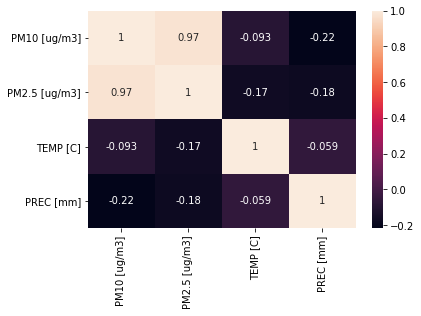

In [27]:
plt = sn.heatmap(corrMatrix, annot=True)
plt.get_figure().savefig('plots/correlogram.png')

In [ ]:
def compare_imputation_methods()
    # TODO
    pass

In [17]:
def calc_percent_NAs(df: pd.DataFrame):
    nans = pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df), columns=['percent']) 
    idx = nans['percent'] > 0
    return nans[idx]

In [18]:
calc_percent_NAs(df)

,percent
PREC [mm],0.216158
PM10 [ug/m3],0.174486
TEMP [C],0.001479
PM2.5 [ug/m3],0.000269


In [52]:
def split_into_train_test_validation_sets(X: np.array) -> Tuple[np.array, np.array, np.array]:
    train_size = int(0.7 * len(X))
    validation_size = int(0.1 * len(X))
    test_size = len(X) - validation_size - train_size

    train_set, test_set, validation_set = X[0:train_size,:], X[train_size: train_size + test_size,:], X[train_size + test_size: train_size + test_size + validation_size, :]
    
    print(f"""
    Total dataset length: {len(X)}
    
    Train set shape: {train_set.shape} ({train_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    Test set shape: {test_set.shape} ({test_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    Validation set shape: {validation_set.shape} ({validation_set.shape[0] / len(X) * 100:0.2f}% of dataset)
    """)

    return train_set, test_set, validation_set

In [50]:
def normalize_dataset(df: pd.DataFrame) -> np.array:
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(df)

In [53]:
scaled_data = normalize_dataset(df=df)
train_set, test_set, validation_set = split_into_train_test_validation_sets(X=scaled_data)


    Total dataset length: 7439
    
    Train set shape: (5207, 4) (70.00% of dataset)
    Test set shape: (1489, 4) (20.02% of dataset)
    Validation set shape: (743, 4) (9.99% of dataset)
    


5207 743 1489
(5207, 4) (1489, 4) (743, 4)
